In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
import polars as pl
from sklearn.model_selection import KFold, GroupKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from tqdm import tqdm
from collections import defaultdict
import warnings
from itertools import combinations

import missingno as msno
import seaborn as sns


warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

INPUT_PATH = '../data/raw/input/'

In [2]:
test = pd.read_parquet(INPUT_PATH + 'test.parquet')
train = pd.read_parquet(INPUT_PATH + 'train.parquet')

train

session_id  index  elapsed_time      event_name       name  \
0         20090312431273200      0             0  cutscene_click      basic   
1         20090312431273200      1          1323    person_click      basic   
2         20090312431273200      2           831    person_click      basic   
3         20090312431273200      3          1147    person_click      basic   
4         20090312431273200      4          1863    person_click      basic   
...                     ...    ...           ...             ...        ...   
26296941  22100221145014656   1600       5483231  navigate_click  undefined   
26296942  22100221145014656   1601       5485166  navigate_click  undefined   
26296943  22100221145014656   1602       5485917  navigate_click  undefined   
26296944  22100221145014656   1603       5486753  navigate_click  undefined   
26296945  22100221145014656   1604       5487952      checkpoint      basic   

          level  page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
0             0   NaN  -413.991405  -159.314686          380.0          494.0   
1             0   NaN  -413.991405  -159.314686          380.0          494.0   
2             0   NaN  -413.991405  -159.314686          380.0          494.0   
3             0   NaN  -413.991405  -159.314686          380.0          494.0   
4             0   NaN  -412.991405  -159.314686          381.0          494.0   
...         ...   ...          ...          ...            ...            ...   
26296941     22   NaN   343.887291    36.701026          483.0          273.0   
26296942     22   NaN   332.696070   141.493178          545.0          221.0   
26296943     22   NaN   369.912859   140.569205          611.0          217.0   
26296944     22   NaN   252.299653   123.805889          526.0          232.0   
26296945     22   NaN          NaN          NaN            NaN            NaN   

          hover_duration                           text            fqid  \
0                    NaN                      undefined           intro   
1                    NaN  Whatcha doing over there, Jo?          gramps   
2                    NaN         Just talking to Teddy.          gramps   
3                    NaN     I gotta run to my meeting!          gramps   
4                    NaN            Can I come, Gramps?          gramps   
...                  ...                            ...             ...   
26296941             NaN                           None            None   
26296942             NaN                           None  chap4_finale_c   
26296943             NaN                           None            None   
26296944             NaN                           None  chap4_finale_c   
26296945             NaN                           None  chap4_finale_c   

                               room_fqid  \
0         tunic.historicalsociety.closet   
1         tunic.historicalsociety.closet   
2         tunic.historicalsociety.closet   
3         tunic.historicalsociety.closet   
4         tunic.historicalsociety.closet   
...                                  ...   
26296941            tunic.capitol_2.hall   
26296942            tunic.capitol_2.hall   
26296943            tunic.capitol_2.hall   
26296944            tunic.capitol_2.hall   
26296945            tunic.capitol_2.hall   

                                                  text_fqid  fullscreen  hq  \
0                      tunic.historicalsociety.closet.intro           0   0   
1         tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
2         tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
3         tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
4         tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
...                                                     ...         ...  ..   
26296941                                               None           0   0   
26296942                         

# 순서
## 1. 결측치 및 각 feature 파악
## 2. 유저별 x_y coordinates 를 이용한 각 방당 움직임 clustering
- unsupervised learning -> feature 생성? 

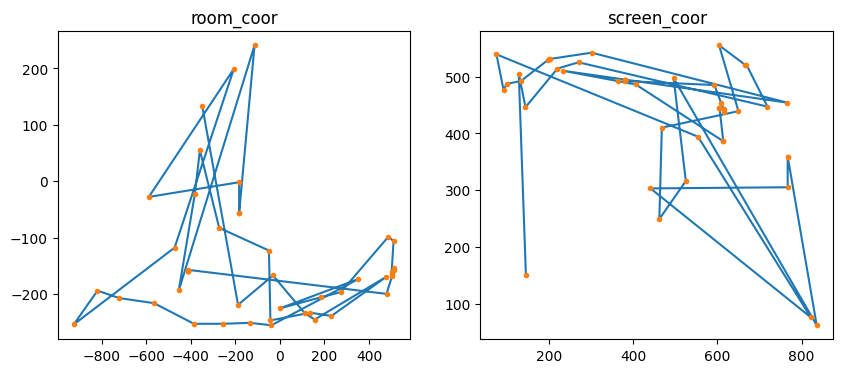

In [35]:
def which_id_room(id, room):
    df = train.loc[(train['session_id'] == id) & (train['room_fqid'] == room)]
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(df.room_coor_x, df.room_coor_y)
    ax[0].plot(df.room_coor_x, df.room_coor_y, '.')
    ax[0].set_title('room_coor')
    ax[1].plot(df.screen_coor_x, df.screen_coor_y)
    ax[1].plot(df.screen_coor_x, df.screen_coor_y, '.')
    ax[1].set_title('screen_coor')
    plt.show()


id1 = 20090312431273200	
room = 'tunic.historicalsociety.closet'
which_id_room(id1, room)

users별로 aggregate (집계) 하나의 데이터만 넘겨줌
coor -> max , min, std, quantile (5%, 95%)
1. embedding? 
2. clustering? -> room_1 room_2 room_3 ... room_19
                    5        2    1            0 

room_coor -> 사용자마다 (1, 1), (100, 99), (1) DF 1번방 ~ 19번방 
x1 y1  x2 y2  --- x100 y100 feature 200개로 
padding
 k-means 나 t-SNE 
kmeans(n_clusters=5).fit(df) -> output: [1,3,2,5,4,--- ] 길이가 len(df)

elapsed time / coord
10 20 30 40  /  
300 -100 200 1000    

room: tunic.historicalsociety.closet


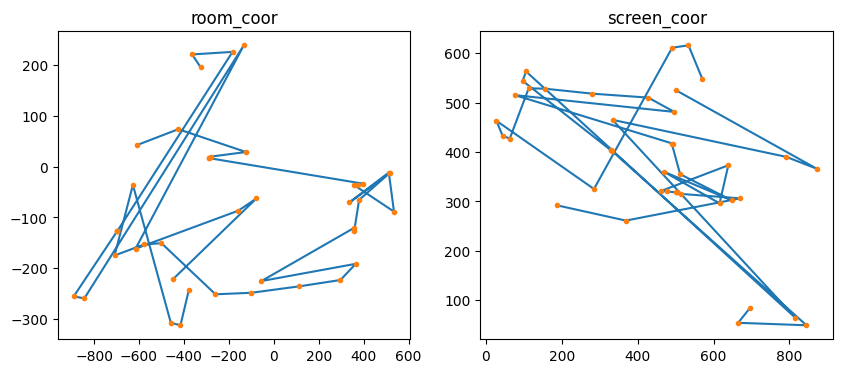

room: tunic.historicalsociety.basement


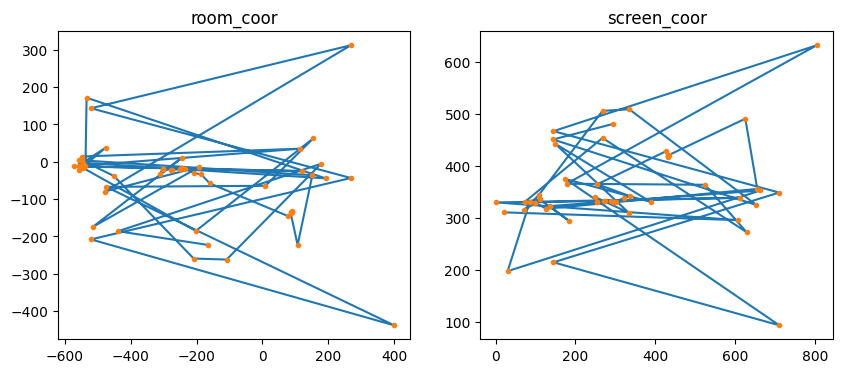

room: tunic.historicalsociety.entry


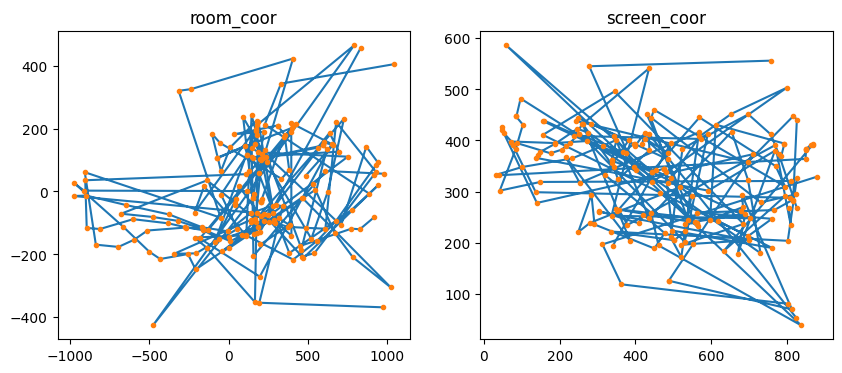

room: tunic.historicalsociety.collection


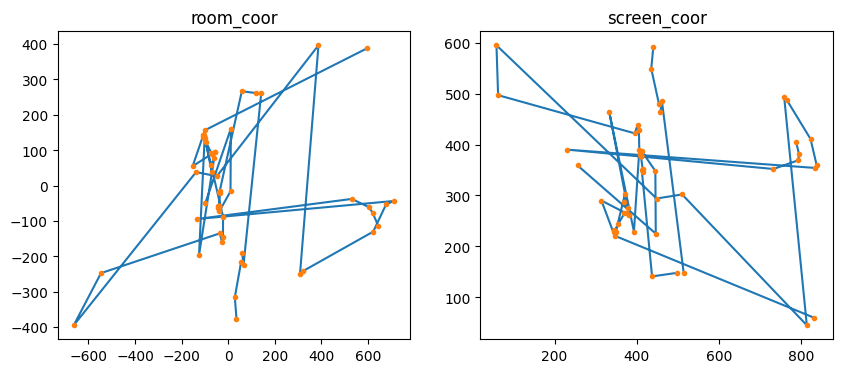

room: tunic.historicalsociety.stacks


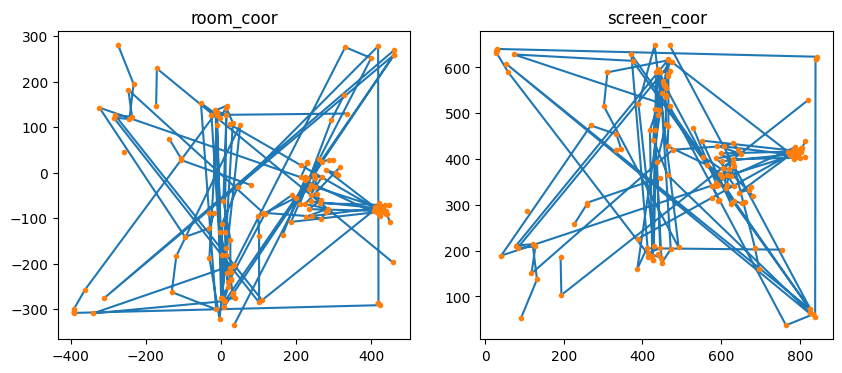

room: tunic.kohlcenter.halloffame


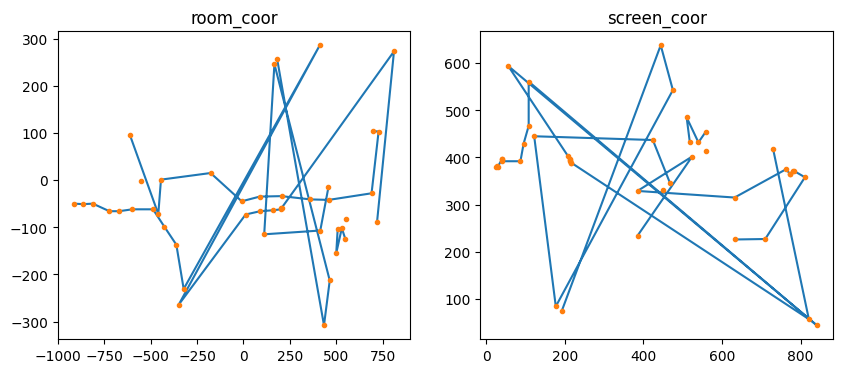

room: tunic.capitol_0.hall


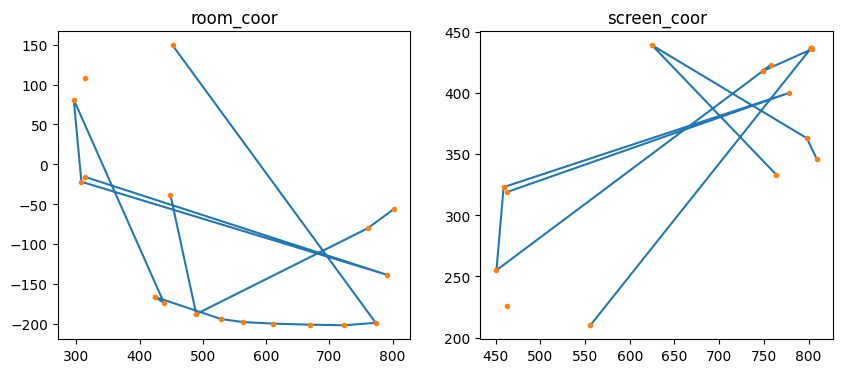

room: tunic.historicalsociety.closet_dirty


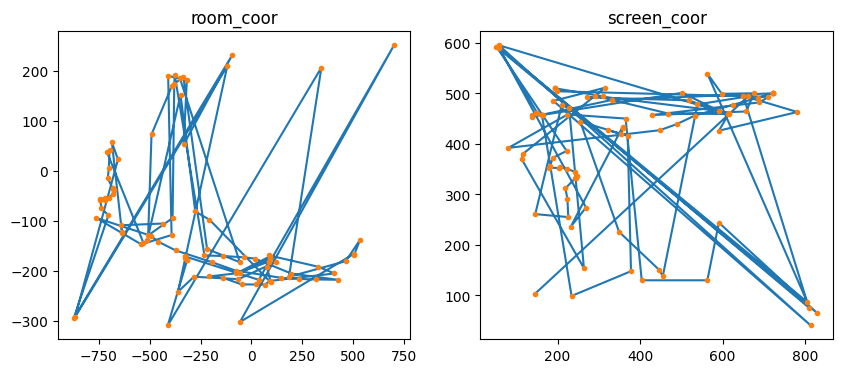

room: tunic.historicalsociety.frontdesk


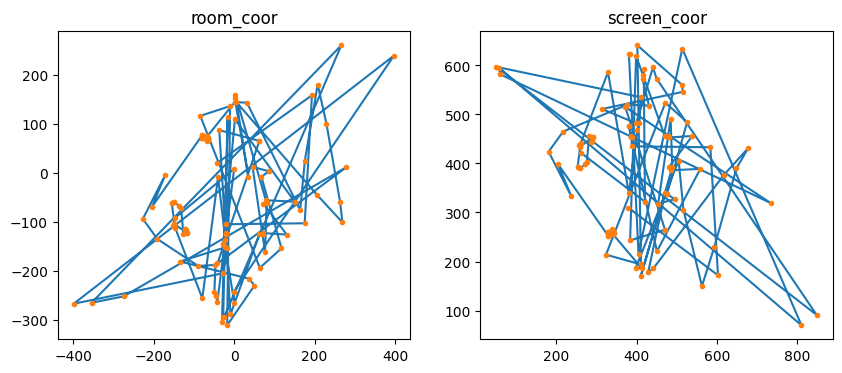

room: tunic.humanecology.frontdesk


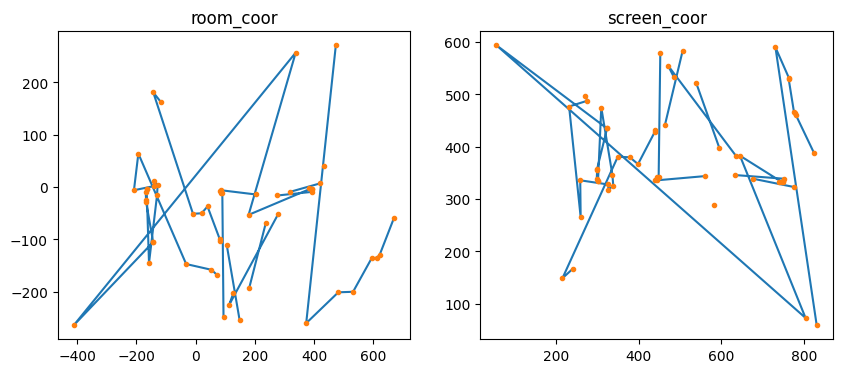

room: tunic.drycleaner.frontdesk


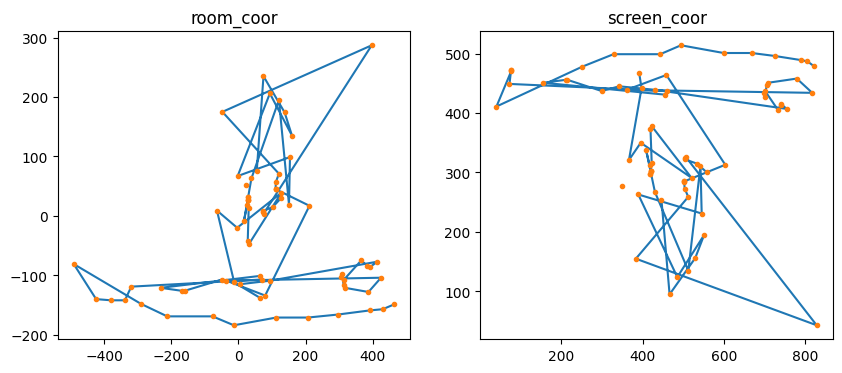

room: tunic.library.frontdesk


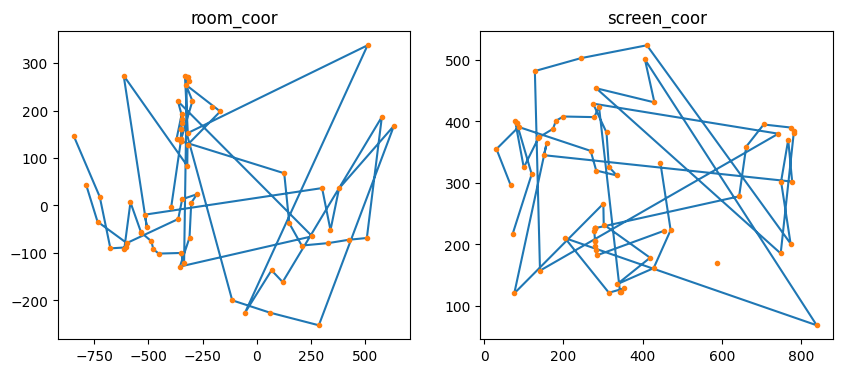

room: tunic.library.microfiche


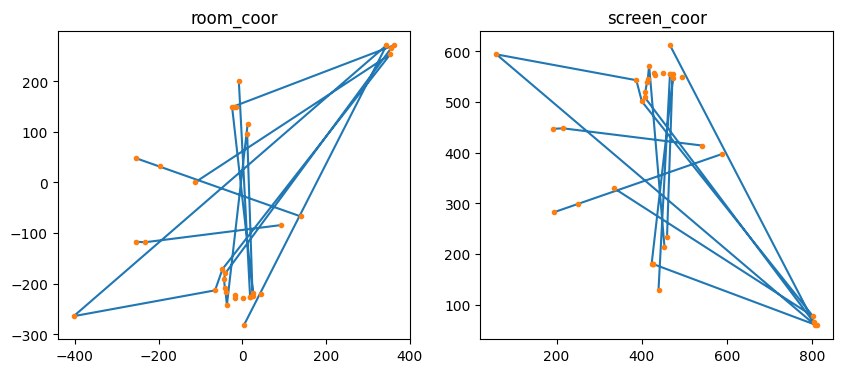

room: tunic.capitol_1.hall


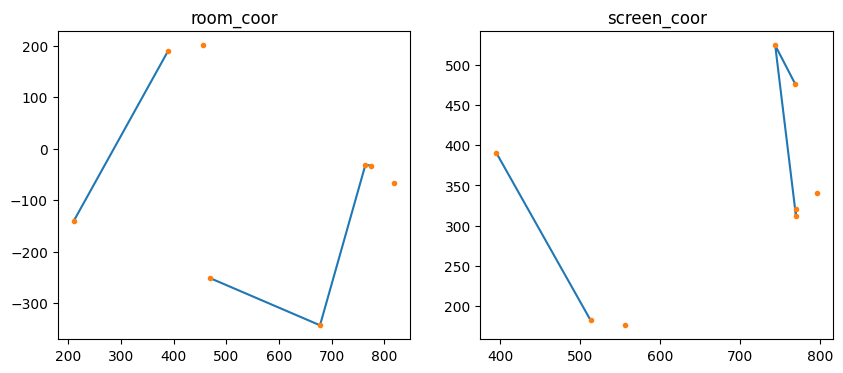

room: tunic.historicalsociety.cage


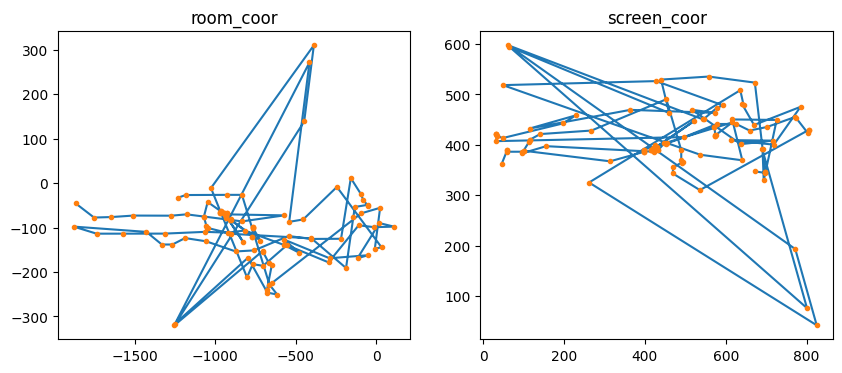

room: tunic.historicalsociety.collection_flag


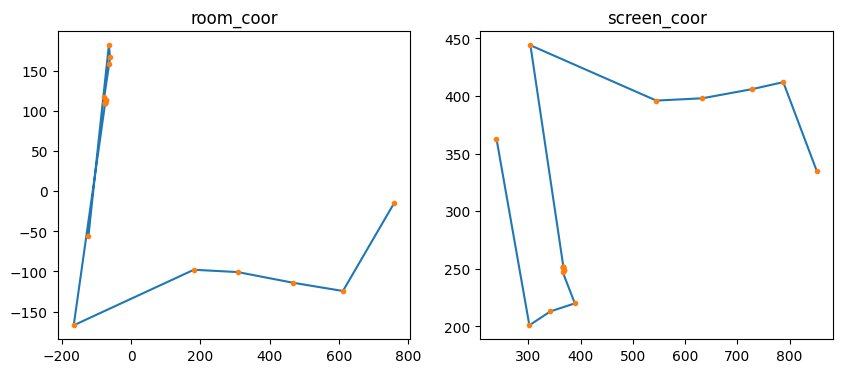

room: tunic.wildlife.center


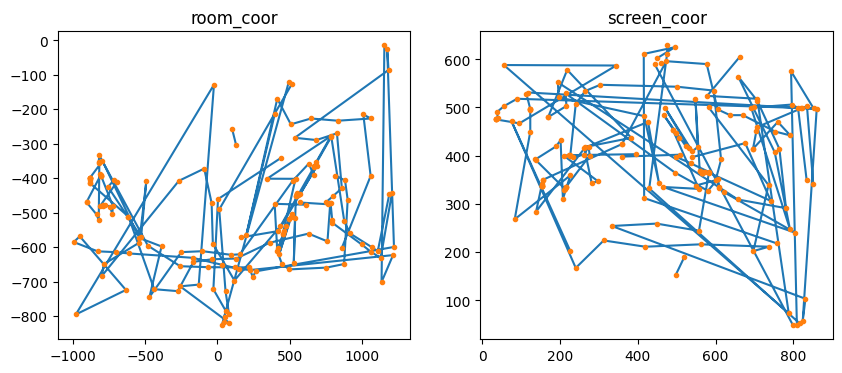

room: tunic.flaghouse.entry


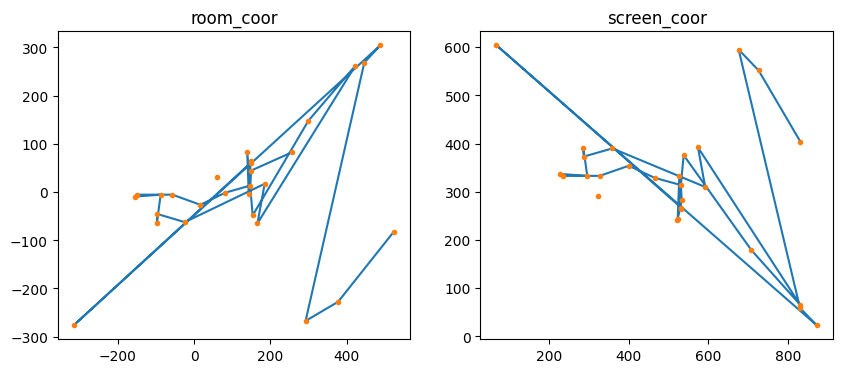

room: tunic.capitol_2.hall


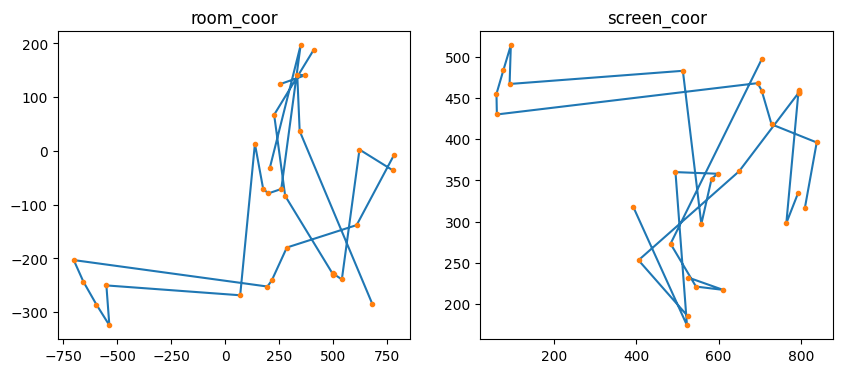

In [29]:
for room in train.room_fqid.unique():
    print(f'room: {room}')
    which_id_room(id1, room)

In [30]:
train.session_id.unique()[:10]

array([20090312431273200, 20090312433251036, 20090312455206810,
       20090313091715820, 20090313571836404, 20090314035813970,
       20090314121766812, 20090314221187252, 20090314363702160,
       20090314441803444])

room: tunic.historicalsociety.closet


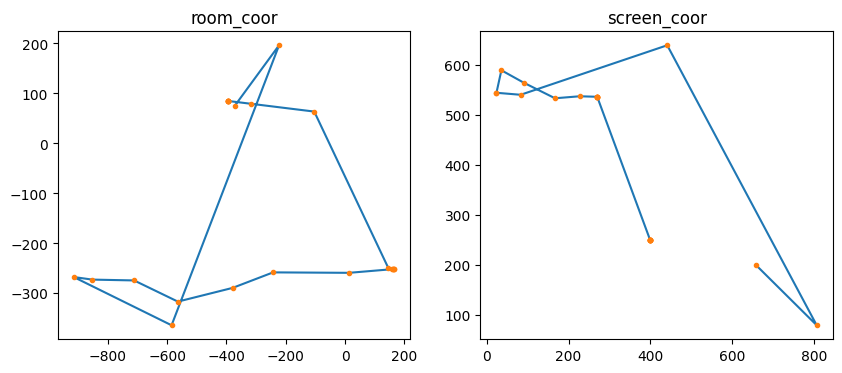

room: tunic.historicalsociety.basement


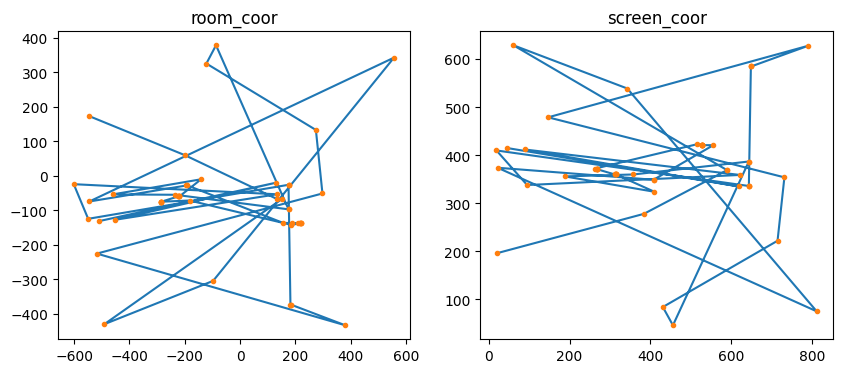

room: tunic.historicalsociety.entry


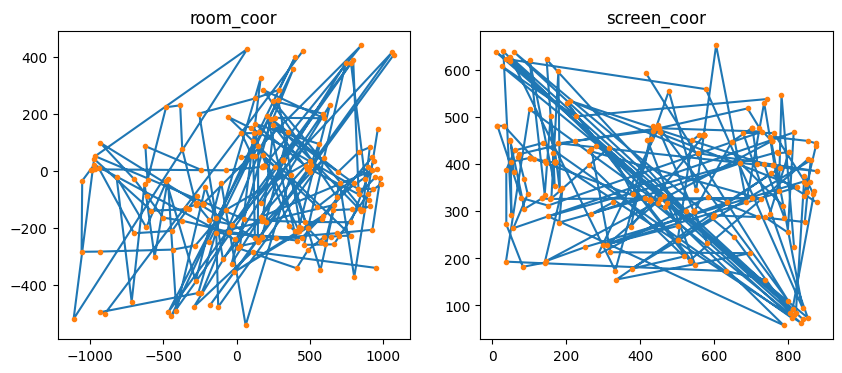

room: tunic.historicalsociety.collection


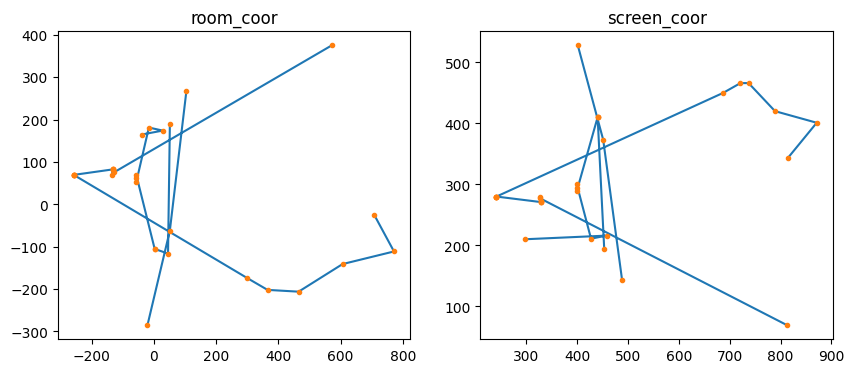

room: tunic.historicalsociety.stacks


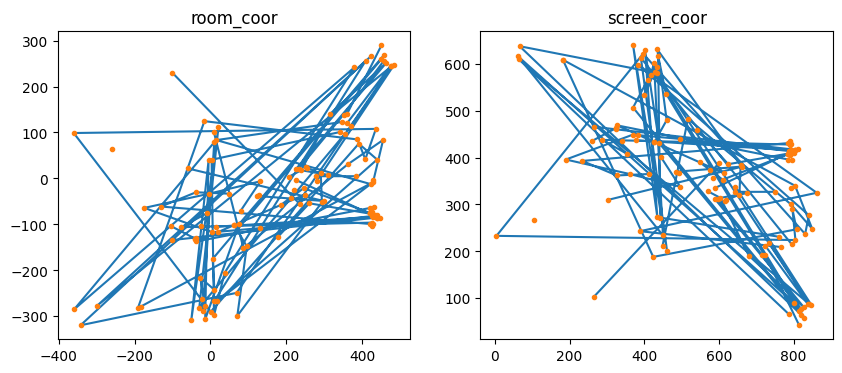

room: tunic.kohlcenter.halloffame


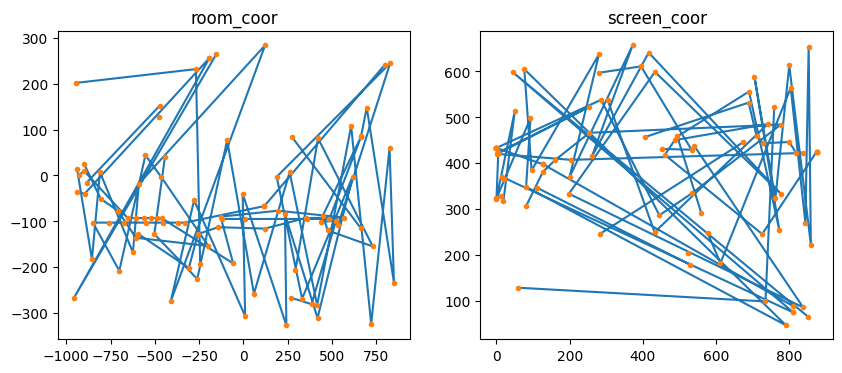

room: tunic.capitol_0.hall


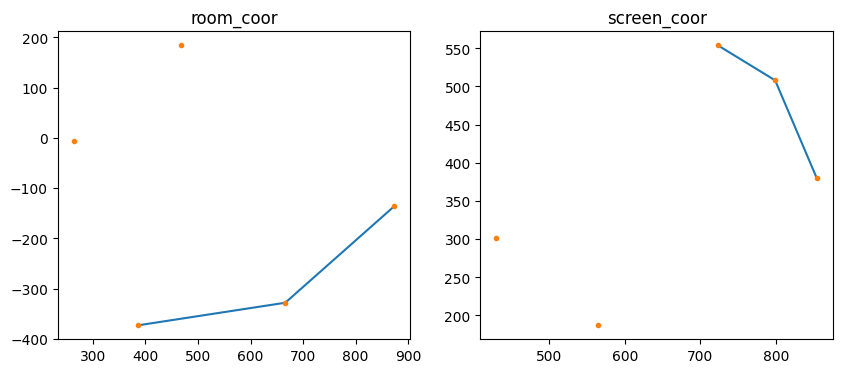

room: tunic.historicalsociety.closet_dirty


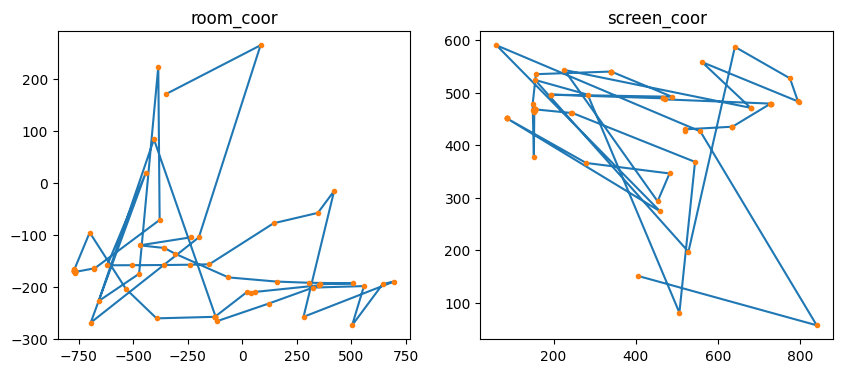

room: tunic.historicalsociety.frontdesk


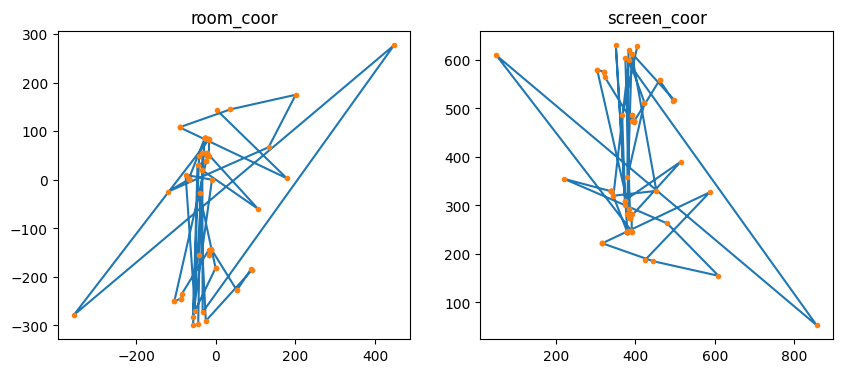

room: tunic.humanecology.frontdesk


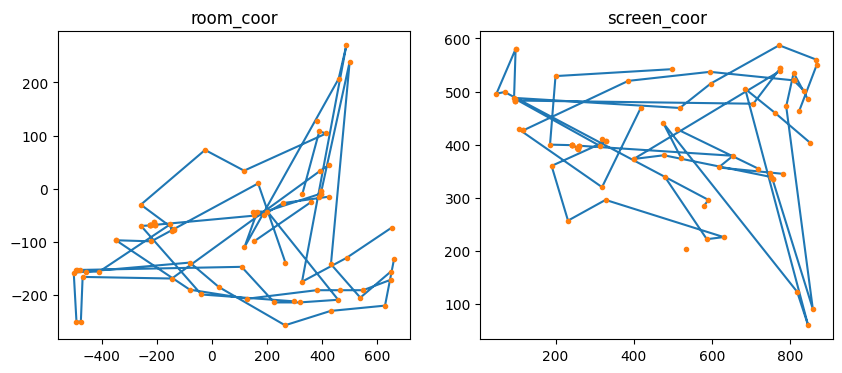

room: tunic.drycleaner.frontdesk


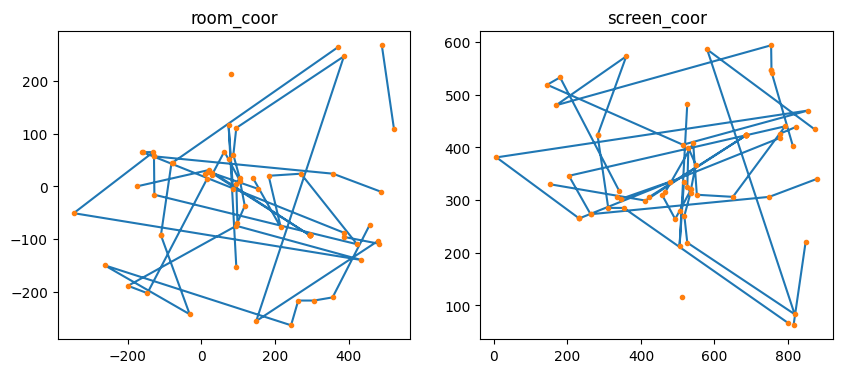

room: tunic.library.frontdesk


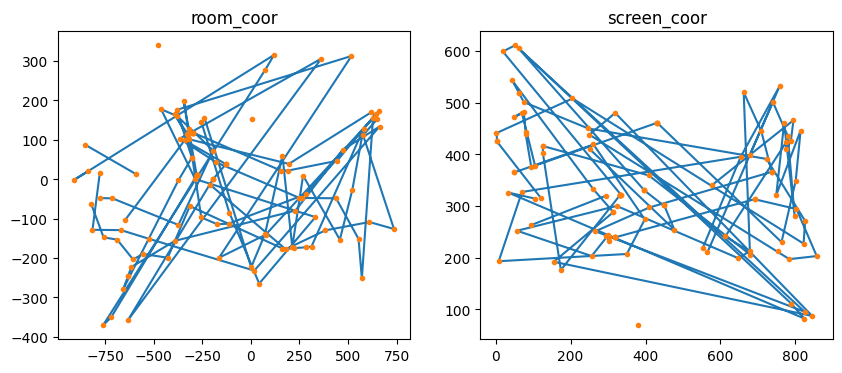

room: tunic.library.microfiche


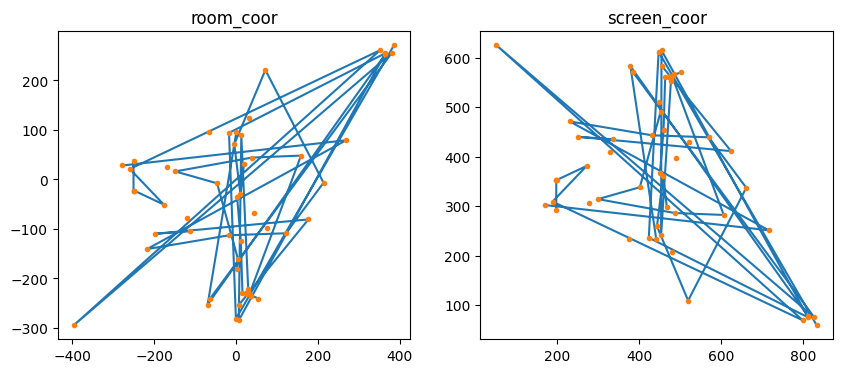

room: tunic.capitol_1.hall


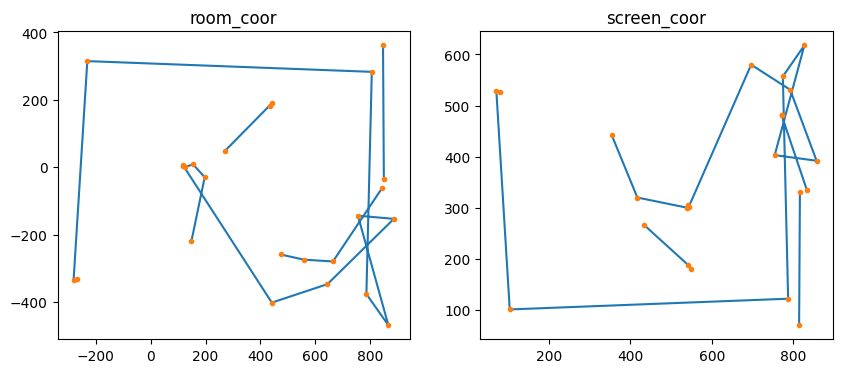

room: tunic.historicalsociety.cage


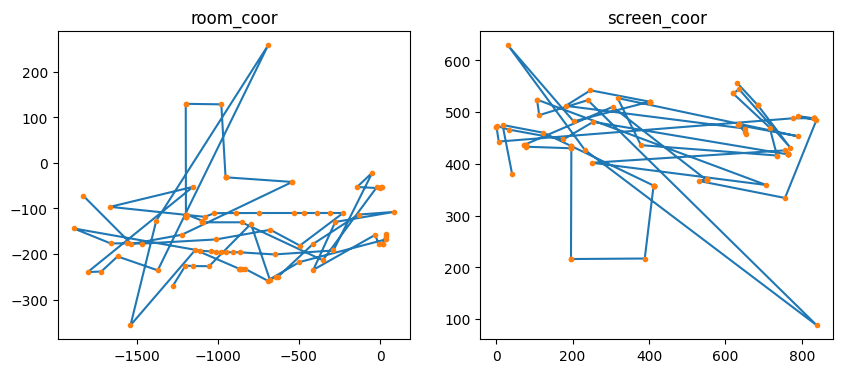

room: tunic.historicalsociety.collection_flag


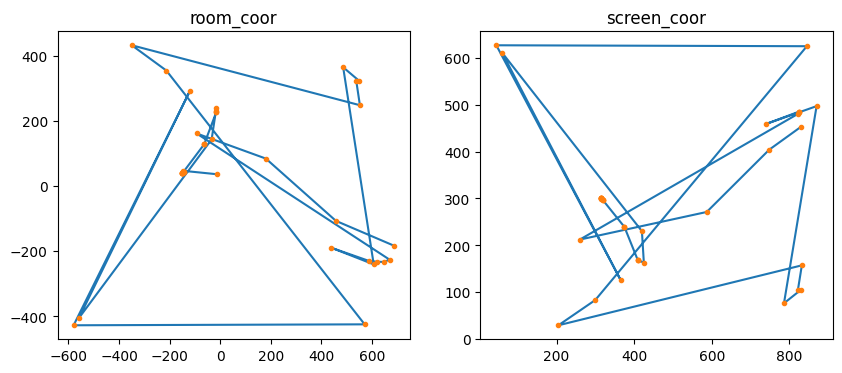

room: tunic.wildlife.center


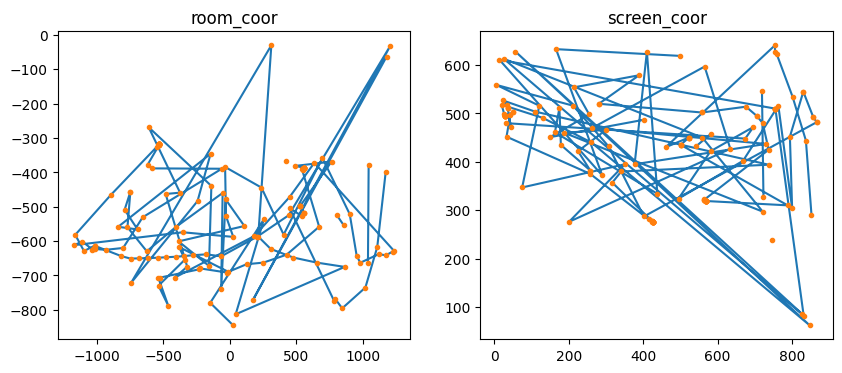

room: tunic.flaghouse.entry


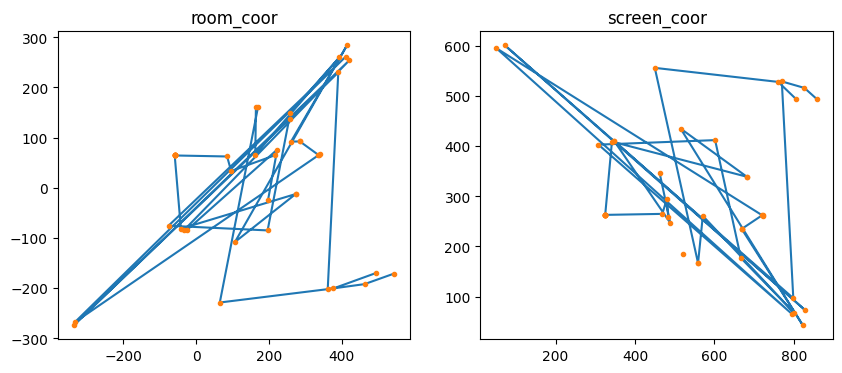

room: tunic.capitol_2.hall


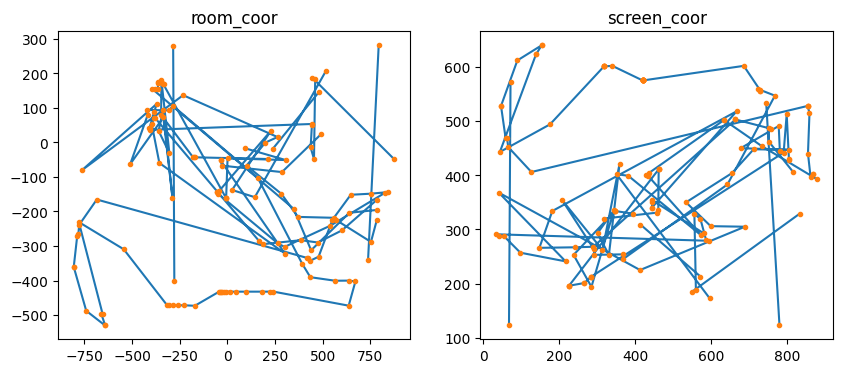

In [31]:
for room in train.room_fqid.unique():
    print(f'room: {room}')
    which_id_room(20090312433251036, room)

## Clustering by coordinates

이동경로를 [100, 33, 100, -88, ...] 과 같이 좌표로 나타냄  
좌표를 길이 1000으로 padding한 뒤 embedding(1000, 100)을 통해 100차원으로 나타냄 (압축)
embedding한 

In [3]:
coor_df = train.loc[:, ['room_coor_x', 'room_coor_y']]
coor_df

room_coor_x  room_coor_y
0         -413.991405  -159.314686
1         -413.991405  -159.314686
2         -413.991405  -159.314686
3         -413.991405  -159.314686
4         -412.991405  -159.314686
...               ...          ...
26296941   343.887291    36.701026
26296942   332.696070   141.493178
26296943   369.912859   140.569205
26296944   252.299653   123.805889
26296945          NaN          NaN

[26296946 rows x 2 columns]

In [9]:
cx_df = train.groupby(['session_id','room_fqid'])['room_coor_x'].apply(list)
cy_df = train.groupby(['session_id','room_fqid'])['room_coor_y'].apply(list)

In [15]:
cx_cy = pd.concat([cx_df, cy_df],axis=1)
cx_cy

room_coor_x  \
session_id        room_fqid                                                                         
20090312431273200 tunic.capitol_0.hall          [240.85698776188613, nan, 280.44217816384867, ...   
                  tunic.capitol_1.hall          [280.2509271558254, 147.15380104082462, 143.58...   
                  tunic.capitol_2.hall                                  [224.19032109521945, nan]   
                  tunic.drycleaner.frontdesk    [71.87578433926964, -48.63833321113594, -15.56...   
                  tunic.flaghouse.entry         [207.04455413343445, 277.4925547051437, 225.08...   
...                                                                                           ...   
22100221145014656 tunic.humanecology.frontdesk  [72.8505361724333, 53.62110311924735, -31.8002...   
                  tunic.kohlcenter.halloffame   [-611.9738083971182, -458.73125860809824, -444...   
                  tunic.library.frontdesk       [-369.7654463694317, -345.90636930558264, -345...   
                  tunic.library.microfiche      [-14.999999999999984, -19.82059012709513, nan,...   
                  tunic.wildlife.center         [165.82276593504417, 421.0234267120858, 689.17...   

                                                                                      room_coor_y  
session_id        room_fqid                                                                        
20090312431273200 tunic.capitol_0.hall          [-69.35957987739589, nan, -19.70583676184349, ...  
                  tunic.capitol_1.hall          [4.882844365028333, -158.23376633002502, -158....  
                  tunic.capitol_2.hall                                  [-60.26867078648686, nan]  
                  tunic.drycleaner.frontdesk    [-46.99999999999997, 43.99999999999999, 22.0, ...  
                  tunic.flaghouse.entry         [-22.761225424683968, 72.93157742118687, 67.31...  
...                                                                                           ...  
22100221145014656 tunic.humanecology.frontdesk  [-167.99999999999997, -158.0, -147.00000000000...  
                  tunic.kohlcenter.halloffame   [96.0, -72.00000000000003, 1.0000000000000064,...  
                  tunic.library.frontdesk       [140.33283020582607, 192.80196371893945, 182.3...  
                  tunic.library.microfiche      [150.0, 150.0, nan, 201.0, -226.0, -226.0, nan...  
                  tunic.wildlife.center         [-571.6316822904341, -553.5479599169771, -364....  

[447676 rows x 2 columns]

In [16]:
tunic.humanecology.frontdesk 
22100221145014656   72.8505 , 53.621,  -31,80         -167.9999 -158.0  -147   feature 200  -> 1000개로 패딩.

SyntaxError: invalid syntax (3444655632.py, line 1)

In [14]:
len(cx_df)

447676

In [13]:
cx_cy

session_id         room_fqid                   
20090312431273200  tunic.capitol_0.hall            [240.85698776188613, nan, 280.44217816384867, ...
                   tunic.capitol_1.hall            [280.2509271558254, 147.15380104082462, 143.58...
                   tunic.capitol_2.hall                                    [224.19032109521945, nan]
                   tunic.drycleaner.frontdesk      [71.87578433926964, -48.63833321113594, -15.56...
                   tunic.flaghouse.entry           [207.04455413343445, 277.4925547051437, 225.08...
                                                                         ...                        
22100221145014656  tunic.humanecology.frontdesk    [-167.99999999999997, -158.0, -147.00000000000...
                   tunic.kohlcenter.halloffame     [96.0, -72.00000000000003, 1.0000000000000064,...
                   tunic.library.frontdesk         [140.33283020582607, 192.80196371893945, 182.3...
                   tunic.library.microfiche

In [39]:
train.loc[(train.session_id == 20090312431273200) & (train.room_fqid == 'tunic.capitol_0.hall')]

session_id  index  elapsed_time      event_name       name  level  \
163  20090312431273200    163        164023  navigate_click  undefined      4   
164  20090312431273200    164        194860      checkpoint      basic      4   
165  20090312431273200    175        221485  navigate_click  undefined      5   
166  20090312431273200    176        222334    person_click      basic      5   
167  20090312431273200    177        223251    person_click      basic      5   
168  20090312431273200    178        223735  navigate_click  undefined      5   
169  20090312431273200    179        224235  navigate_click  undefined      5   
170  20090312431273200    180        224802  navigate_click  undefined      5   
171  20090312431273200    181        225803  navigate_click  undefined      5   
172  20090312431273200    182        226643       map_hover      basic      5   
173  20090312431273200    183        228133       map_click  undefined      5   

     page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
163   NaN   240.856988   -69.359580          415.0          343.0   
164   NaN          NaN          NaN            NaN            NaN   
165   NaN   280.442178   -19.705837          653.0          321.0   
166   NaN   272.983492   -19.233581          649.0          321.0   
167   NaN   240.848426  -228.217450          628.0          459.0   
168   NaN   331.714689  -220.627225          688.0          454.0   
169   NaN   404.147223  -226.491396          716.0          454.0   
170   NaN   612.402686  -230.577224          804.0          454.0   
171   NaN   755.120185  -213.104481          824.0          441.0   
172   NaN          NaN          NaN            NaN            NaN   
173   NaN   456.774049   167.182115          559.0          198.0   

     hover_duration                                    text  \
163             NaN                                    None   
164             NaN                                    None   
165             NaN                                    None   
166             NaN  What are you still doing here,  Jolie?   
167             NaN    Go find your grampa and get to work!   
168             NaN                                    None   
169             NaN                                    None   
170             NaN                                    None   
171             NaN                                    None   
172           750.0                                    None   
173             NaN                                    None   

                        fqid             room_fqid  \
163             chap1_finale  tunic.capitol_0.hall   
164           chap1_finale_c  tunic.capitol_0.hall   
165                     boss  tunic.capitol_0.hall   
166                     boss  tunic.capitol_0.hall   
167                     boss  tunic.capitol_0.hall   
168                     None  tunic.capitol_0.hall   
169                     None  tunic.capitol_0.hall   
170                     None  tunic.capitol_0.hall   
171                  toentry  tunic.capitol_0.hall   
172                  toentry  tunic.capitol_0.hall   
173  tunic.historicalsociety  tunic.capitol_0.hall   

                                  text_fqid  fullscreen  hq  music level_group  
163                                    None           0   0      1         0-4  
164                                    None           0   0      1         0-4  
165                                    None           0   0      1        5-12  
166  tunic.capitol_0.hall.boss.talktogramps           0   0      1        5-12  
167  tunic.capitol_0.hall.boss.talktogramps           0   0      1        5-12  
168                                    None           0   0      1        5-12  
169                                    None           0   0      1        5-12  
170                                    None           0   0      1        5-12  
171                                    None           0   0      1        5

Dynamic Time Warping 을 이용한 시계열 클러스터링  
https://github.com/wannesm/dtaidistance

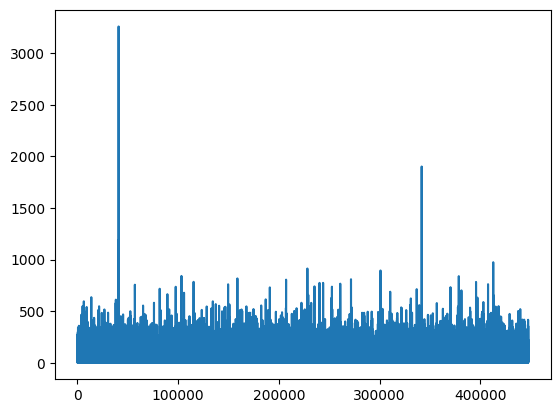

In [47]:
plt.plot(train.groupby(['session_id', 'room_fqid'])['room_coor_x'].size().values)